In [1]:
import gsw, time, datetime, os, glob, xgcm, matplotlib, xarray as xr, numpy as np, dask.array as da, pandas as pd, cartopy.crs as ccrs
from scipy import signal, fft
import cartopy.mpl.ticker as cticker, string
import cartopy.feature as cfeature
from scipy.stats import bootstrap
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=6)
client = Client(cluster)
from scipy.interpolate import griddata

In [3]:
!pip install astropy[recommended] --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 5.5 MB/s eta 0:00:00m eta 0:00:0136m0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 10.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:009.0 MB/s eta 0:00:01m


In [4]:
from astropy.convolution import (Gaussian2DKernel, CustomKernel,
                                 interpolate_replace_nans,
                                  convolve)
import glob
import os
import xarray as xr
import numpy as np
import datetime
import warnings
import copy
import itertools
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd


def get_kernel_sigma(delta_in,delta_out):
    """Get the Gaussian filter standard deviation desired
    to get a kernel with a full width 1/2 power
    width of delta_out, when delta_in is the pixel size.
    """

    sigma_out = delta_out/np.sqrt(2*np.log(2))/2

    return sigma_out/delta_in # in pixels


def filt_single(u,delta_out=5000.,delta_in=500.,keep_nan=False):
    """Filter the velocity components to the desired spatial
    resolution, given a data set where the mask has been set."""
    sz = get_kernel_sigma(delta_in,delta_out)
    kernel = Gaussian2DKernel(sz)

    u = convolve(u,kernel,nan_treatment='interpolate',preserve_nan=True)

    return u


def getTimeAvgData(time_center,time_span,kw):
   
    # time_center: center datetime64
    # time_span: hours surrounding time_center to average
    # kw: variable in netcdf files to average
 
 
    start_time = time_center - np.timedelta64(int(time_span/2),'h')
    end_time = time_center + np.timedelta64(int(time_span/2),'h')
 
    data_sel = data_all[kw]
    data_sel = data_sel.sel(time=slice(start_time,end_time))
 
    weights = np.hamming(len(data_sel['time'].values))
    weights = weights/np.sum(weights)
   
    data_sel = data_sel * weights[:,np.newaxis,np.newaxis]
   
    data_sel = data_sel.sum(dim='time',skipna=True)
 
    return data_sel.values
   

def addTimeDimCoarse(ds):

    fn = os.path.basename(ds.encoding["source"])
    time_str = fn.split('.')[0].split('_')[-1]

    time = pd.to_datetime(time_str, format='%Y%m%d%H')
    ds = ds.expand_dims(time=[time])
    return ds

####kernel = Gaussian2DKernel(x_stddev=sigma_x)
####eta_space_time_avg_temp = convolve_fft(eta_time_avg,kernel,nan_treatment='interpolate',preserve_nan=True)

In [3]:
du = []

##################### uncoupled model #####################
time = pd.date_range("2012-05-01", "2013-02-23", freq="d") #winter
for fi in time:
    fuu = "/HOME/users/fcampos/outputs/kuroshio/uncoupled/U/U_KExt_z0m_llc_4km_{}.nc".format(fi.strftime("%Y%m%d"))
    fuv = "/HOME/users/fcampos/outputs/kuroshio/uncoupled/V/V_KExt_z0m_llc_4km_{}.nc".format(fi.strftime("%Y%m%d"))
    ouu = xr.open_mfdataset(fuu, concat_dim="time", combine='nested', parallel=True,)
    ouv = xr.open_mfdataset(fuv, concat_dim="time", combine='nested', parallel=True,)
    ouu = ouu.combine_first(ouv)
    du.append(ouu)
    del ouu, ouv  
du = xr.concat(du, dim='time').transpose("longitude", "latitude", "time")#.interpolate_na(dim="longitude")

In [4]:
dc = []

##################### coupled model #####################
time = pd.date_range("2020-05-01", "2021-02-23", freq="d")

for fi in time:    
    fcu = "/HOME/users/fcampos/outputs/kuroshio/coupled/U/U_KExt_z0m_coas_4km_{}.nc".format(fi.strftime("%Y%m%d"))
    fcv = "/HOME/users/fcampos/outputs/kuroshio/coupled/V/V_KExt_z0m_coas_4km_{}.nc".format(fi.strftime("%Y%m%d")) 
    ocu = xr.open_mfdataset(fcu, concat_dim="time", combine='nested', parallel=True,)
    ocv = xr.open_mfdataset(fcv, concat_dim="time", combine='nested', parallel=True,)
    ocu = ocu.combine_first(ocv)
    dc.append(ocu)
    del ocu, ocv    
dc = xr.concat(dc, dim='time').transpose("longitude", "latitude", "time")#.interpolate_na(dim="longitude")

In [5]:
U_coas_daily = dc.U.resample(time="7D").mean(dim="time")
V_coas_daily = dc.V.resample(time="7D").mean(dim="time")
U_llc_daily = du.U.resample(time="7D").mean(dim="time")
V_llc_daily = du.V.resample(time="7D").mean(dim="time")

In [7]:
U_coas_daily_c, V_coas_daily_c, U_llc_daily_c , V_llc_daily_c = [], [], [], []
time = pd.date_range("2020-05-01", "2021-02-23", freq="7d")
for i in range(time.size):
    print(i)
    out = filt_single(U_coas_daily[:,:,i],delta_out=0.25*111195/1000,delta_in=0.04*111195/1000,keep_nan=True)
    U_coas_daily_c.append(out)
    out = filt_single(V_coas_daily[:,:,i],delta_out=0.25*111195/1000,delta_in=0.04*111195/1000,keep_nan=True)
    V_coas_daily_c.append(out)
    out = filt_single(U_llc_daily[:,:,i],delta_out=0.25*111195/1000,delta_in=0.04*111195/1000,keep_nan=True)
    U_llc_daily_c.append(out)    
    out = filt_single(V_llc_daily[:,:,i],delta_out=0.25*111195/1000,delta_in=0.04*111195/1000,keep_nan=True)
    V_llc_daily_c.append(out)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [11]:
np.savez_compressed("./MKE_1week.npz",
                    mean_ke_coas=MKE_coas,
                    mean_ke_llc=MKE_llc, 
                    mean_eke_coas=MEKE_coas,
                    mean_eke_llc=MEKE_llc,
                   )

In [8]:
MKE_coas = 0.5*(np.mean(np.array(U_coas_daily_c),axis=0)**2+np.mean(np.array(V_coas_daily_c),axis=0)**2)
MKE_llc = 0.5*(np.mean(np.array(U_llc_daily_c),axis=0)**2+np.mean(np.array(V_llc_daily_c),axis=0)**2)

In [9]:
au = np.array(U_coas_daily_c)-np.mean(np.array(U_coas_daily_c),axis=0)[None,:,:]
av = np.array(V_coas_daily_c)-np.mean(np.array(V_coas_daily_c),axis=0)[None,:,:]
MEKE_coas = 0.5*(np.mean(au*au,axis=0)+np.mean(av*av,axis=0))

In [10]:
au = np.array(U_llc_daily_c)-np.mean(np.array(U_llc_daily_c),axis=0)[None,:,:]
av = np.array(V_llc_daily_c)-np.mean(np.array(V_llc_daily_c),axis=0)[None,:,:]
MEKE_llc = 0.5*(np.mean(au*au,axis=0)+np.mean(av*av,axis=0))

In [14]:
loaded_summer = np.load("./MKE_1week.npz")
mke_coas, mke_llc = loaded_summer['mean_ke_coas'], loaded_summer['mean_ke_llc']
meke_coas, meke_llc = loaded_summer['mean_eke_coas'], loaded_summer['mean_eke_llc']
du = xr.open_dataset("/media/fcampos/DATA_SAVE/data_fernando/data_kuroshio/V_KExt_z0m_llc_4km_20130211.nc")
longitude_coas, latitude_coas = du.longitude.compute(), du.latitude.compute()

loaded_summer = np.load("./MKE_AVISO.npz")
mke_aviso, meke_aviso = loaded_summer['mean_ke_aviso'], loaded_summer['mean_eke_aviso']
longitude_aviso, latitude_aviso = loaded_summer['longitude_aviso'], loaded_summer['latitude_aviso']

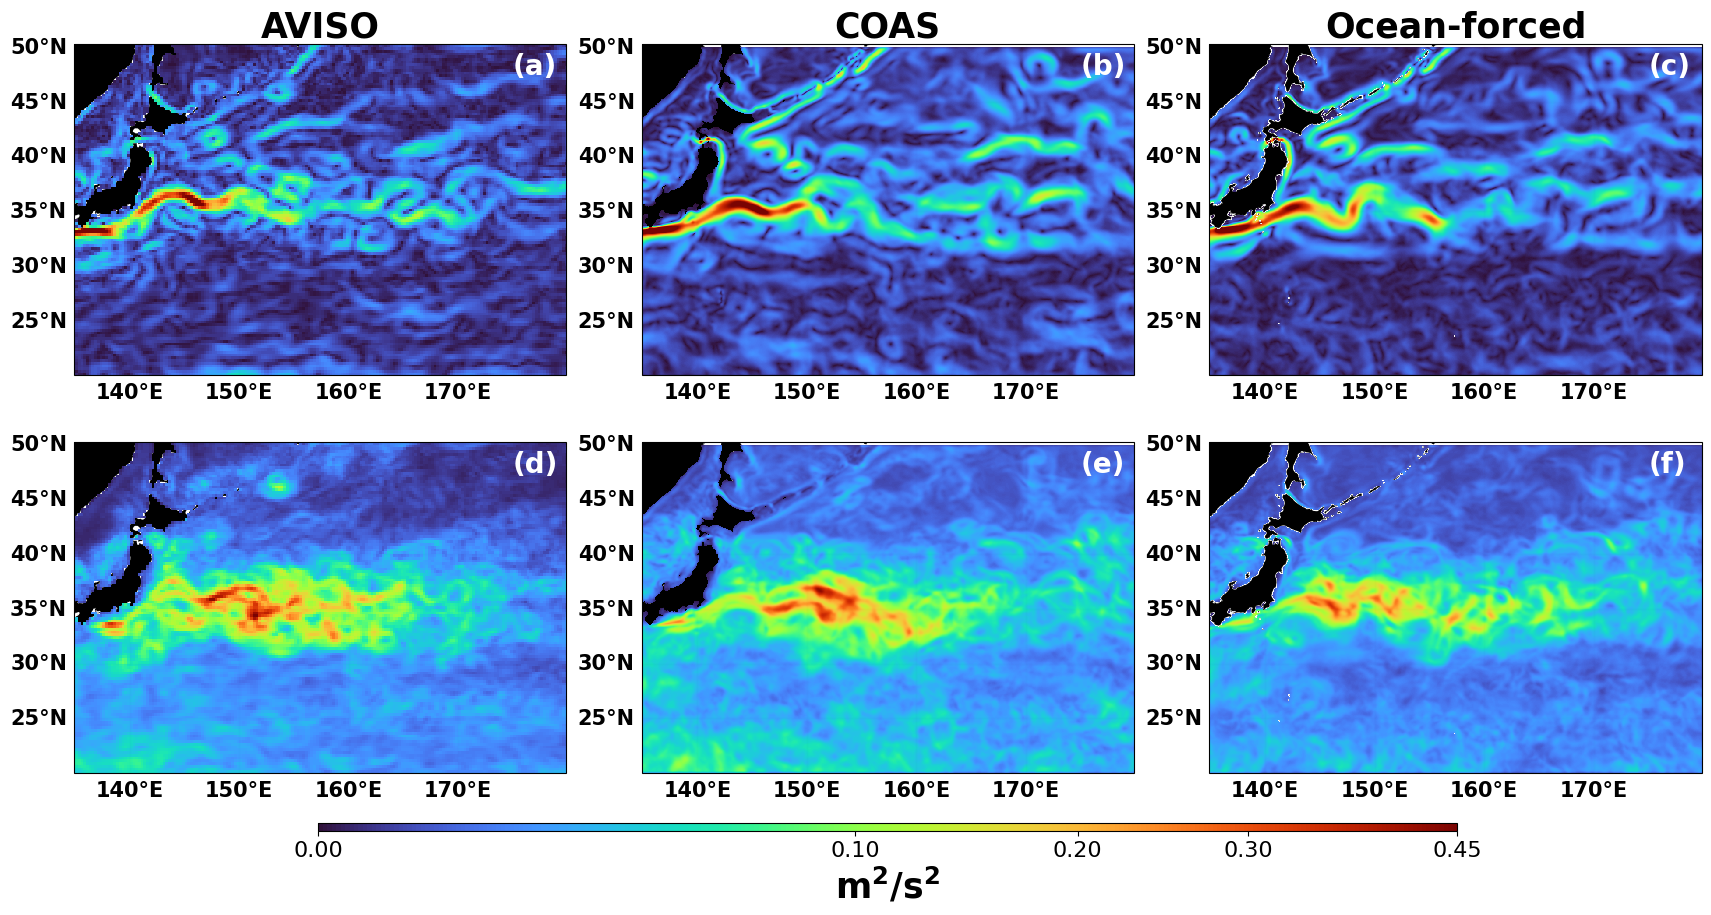

In [45]:
alphabet, num = string.ascii_lowercase, 0

fig, ax = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(17,9),constrained_layout=True)

az = ax[0,0].pcolormesh(longitude_aviso, latitude_aviso, mke_aviso, 
                        transform = ccrs.PlateCarree(),rasterized=True, cmap="turbo",
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))
xx,yy=np.meshgrid(longitude_coas,latitude_coas)
az = ax[0,1].pcolormesh(xx, yy, mke_coas.T, 
                        transform = ccrs.PlateCarree(),rasterized=True,cmap="turbo", 
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))
az = ax[0,2].pcolormesh(xx, yy, mke_llc.T, 
                        transform = ccrs.PlateCarree(),rasterized=True, cmap="turbo", 
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))

az = ax[1,0].pcolormesh(longitude_aviso, latitude_aviso, meke_aviso, 
                        transform = ccrs.PlateCarree(),rasterized=True,cmap="turbo", 
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))
az = ax[1,1].pcolormesh(xx,yy, meke_coas.T, 
                        transform = ccrs.PlateCarree(),rasterized=True, cmap="turbo", 
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))
az = ax[1,2].pcolormesh(xx,yy, meke_llc.T, 
                        transform = ccrs.PlateCarree(),rasterized=True,cmap="turbo", 
                        norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=0.45))

for i in range(3):
    ax[0,i].text(175,47.5, "("+str(alphabet[num])+")", fontweight="bold", color="white", fontsize=20)
    ax[1,i].text(175,47.5, "("+str(alphabet[num+3])+")", fontweight="bold", color="white", fontsize=20)
    num=num+1
    for j in range(2):
        ax[j,i].add_feature(cfeature.LAND.with_scale('10m'), facecolor='black')
        ax[j,i].set_extent([134.9,longitude_aviso.max(),
                    latitude_coas.min(),48])
        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               linewidth=1, color='black', alpha=0.01,)
        gl.top_labels = mticker.FixedLocator([135,145,155,165,175])
        gl.right_labels = mticker.FixedLocator([20, 30, 40])
        gl.top_labels = False
        gl.right_labels=False
        gl.xlabel_style = {'color': 'black', 'weight': 'bold', "size":15}
        gl.ylabel_style = {'color': 'black', 'weight': 'bold', "size":15}
ax[0,0].set_title("AVISO", fontsize=25, fontweight="bold")
ax[0,1].set_title("COAS", fontsize=25, fontweight="bold")
ax[0,2].set_title("Ocean-forced", fontsize=25, fontweight="bold")
        
cb = plt.colorbar(az, ax=ax, orientation='horizontal', pad =0.03, aspect=150, fraction=0.01, ticks=[0, 0.1, 0.2, 0.3, 0.45])
cb.ax.tick_params(labelsize=16) 

cb.set_label(label="$\mathbf{m^{2}/s{^2}}$", size=25,)
plt.savefig("./figure01.pdf", dpi=500)     